## Import necessary libraries and function applying YOLOv3 on a single image

In [23]:
import numpy as np
import time, glob, os, natsort, sys, cv2, json, argparse
import matplotlib.pyplot as plt
from sklearn import metrics
import xml.etree.ElementTree as ET


labelsPath = os.path.join(os.getcwd(), "yolo_files/classes.names")
weightsPath = os.path.join(os.getcwd(), "yolo_files/yolov3.weights")
configPath = os.path.join(os.getcwd(), "yolo_files/yolov3.cfg")
# Recommended parameters by authors. You can play with it.
confidence_t = 0.5
threshold_t = 0.3
img_size = 416


weather = "sunny"  # Weather you want to process
save = False       # Whether you want to save predicted dictionaries or not

xml_paths = glob.glob(os.path.join(os.getcwd(), "weather_data/"+str(weather)+"_annotations/*"))
sorted_xml_paths = natsort.natsorted(xml_paths, reverse=False)
folder_dirs = glob.glob(os.path.join(os.getcwd(), "weather_data/"+str(weather)+"_data/*"))
sorted_folder_dirs = natsort.natsorted(folder_dirs, reverse=False)

iou_thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]


In [24]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])

	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)

	# return the intersection over union value
	return iou

def CalculateAveragePrecision(rec, prec):
    mrec = []
    mrec.append(0)
    [mrec.append(e) for e in rec]
    mrec.append(1)
    mpre = []
    mpre.append(1)
    [mpre.append(e) for e in prec]
    mpre.append(0)
    for i in range(len(mpre) - 1, 0, -1):
        mpre[i - 1] = max(mpre[i - 1], mpre[i])
    ii = []
    for i in range(len(mrec) - 1):
        if mrec[1:][i] != mrec[0:-1][i]:
            ii.append(i + 1)
    ap = 0
    for i in ii:
        ap = ap + np.sum((mrec[i] - mrec[i - 1]) * mpre[i])
    return ap

In [25]:
# This class takes image parameter which should be a 3d numpy array and returns two dictionaries. One dictionary
# is for car prediction and other one for bus

# Dictionary has two keys
#     (1) 'Confidences': Contains list of confidence scores of all detections
#     (2) 'locations': Contains list of locations (BBox: (x1, y1, x2, y2)) of all detected vehicles 

def yolov3_process(image):
    LABELS = open(labelsPath).read().strip().split('\n')
    names = []
    np.random.seed(42)
    COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),dtype="uint8")

    # image should be a 3d numpy array
    (H, W) = image.shape[:2]

    # Let's apply Yolo dectector using pretrained weights
    net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)
    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (img_size, img_size),swapRB=True, crop=False)
    net.setInput(blob)
    start = time.time()
    layerOutputs = net.forward(ln)
    end = time.time()
#     print("[INFO] YOLO took {:.6f} seconds".format(end - start))

    # Let us assign class labels to the objects from layerOutputs
    boxes = []
    confidences = []
    classIDs = []

    classname = []
    list_of_vehicles = ["car", "bus"]
    locations_car = []
    confi_car = []

    locations_bus = []
    confi_bus = []
    
    for output in layerOutputs:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]
            if confidence > confidence_t:
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    # apply non-maxima suppression to suppress weak, overlapping bounding

    idxs = cv2.dnn.NMSBoxes(boxes, confidences, confidence_t,threshold_t)

    # Let's make output image and store class labels in a list
    # ensure at least one detection exists
    if len(idxs) > 0:
        # loop over the indexes we are keeping
        for i in idxs.flatten():
            # extract the bounding box coordinates
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])

            # draw a bounding box rectangle and label on the image
            if (LABELS[classIDs[i]] == "car"):
                confi_car.append(confidences[i])
                locations_car.append([x, y, x+w, y+h])
            elif (LABELS[classIDs[i]] == "bus"):
                confi_bus.append(confidences[i])
                locations_bus.append([x, y, x+w, y+h])
                
    dictionary_car = {'confidences': confi_car, 'locations': locations_car}
    dictionary_bus = {'confidences': confi_bus, 'locations': locations_bus}

    return dictionary_car, dictionary_bus

## Apply YOLOv3 on all images in folder. Returns a dictionary consisting of two keys
### (1) 'image_id': List of numbering of all images
### (2) 'frame_predictions': List of dictionaries for each image

In [27]:
total_pred_car = 0
img_id = []
pred_car = []

total_pred_bus = 0
pred_bus = []
print("Total folders to be processed in this weather: "+str(len(sorted_folder_dirs)))

for k, folder in enumerate(sorted_folder_dirs):
    print("Processing folder # "+str(k+1))
    tree = ET.parse(sorted_xml_paths[k])
    root = tree.getroot()
    ignored_boxes = tree.findall('ignored_region')
    path = folder+"/*.jpg"
    file_paths = glob.glob(path)
    sorted_file_paths = natsort.natsorted(file_paths, reverse=False)
    for i, f in enumerate(sorted_file_paths):
#         print(f)
#         print(i+1)
        img_id.append(i+1)
        img = cv2.imread(f, 1)
        for child in ignored_boxes[0]:
            aa = child.attrib
            x1 = int(float(aa.get('left')))
            y1 = int(float(aa.get('top')))
            w = int(float(aa.get('width')))
            h = int(float(aa.get('height')))
            x2 = x1+w
            y2 = y1+h

            for j in range (h):
                for k in range (w):
                    img[y1+j, x1+k] = [255, 255, 255]

        dict_car, dict_bus = yolov3_process(img)
#         dict_car, dict_bus = maskrcnn_process(img)
        total_pred_car = total_pred_car + len(dict_car['locations'])
        pred_car.append(dict_car)
        
        total_pred_bus = total_pred_bus + len(dict_bus['locations'])
        pred_bus.append(dict_bus)

print("Number of images processed: "+str(len(img_id)))
print("Total number of cars detected: "+str(total_pred_car))
print("Total number of buses detected: "+str(total_pred_bus))

dict_pred_car = {'image_id': img_id, 'frame_predictions': pred_car}
dict_pred_bus = {'image_id': img_id, 'frame_predictions': pred_bus}



Total folders to be processed in this weather: 1
Processing folder # 1
Number of images processed: 1470
Total number of cars detected: 6696
Total number of buses detected: 6


In [28]:
if save:
    with open("results/yolov3_car_"+str(weather)+"_pred_dict.json", "w") as fp:
        json.dump(dict_pred_car, fp, sort_keys=True, indent=4)
    with open("results/yolov3_bus_"+str(weather)+"_pred_dict.json", "w") as fp:
        json.dump(dict_pred_bus, fp, sort_keys=True, indent=4)

## Load annotation. Returns a dictionary consisting of two keys:
### (1) 'image_id' : List of numbering of all images
### (2) 'frame_ground' : List of dictionaries for all images

In [29]:
import xml.etree.ElementTree as ET

img_id = []
ground_car = []
ground_bus = []
total_ground_car = 0
total_ground_bus = 0
for k, folder in enumerate(sorted_xml_paths):
    tree = ET.parse(folder)
    root = tree.getroot()
    frames = tree.findall('frame')
    path = sorted_folder_dirs[k]+"/*.jpg"
    file_paths = glob.glob(path)
    num = len(file_paths)

    if len(frames)!=num:
        print("Number of images and their annotations are not same. You may need to remove some images whose annotations are not provided in UA-DETRAC annotation")
    else:
        for i in range (num):
            gg = frames[i].attrib
            img_id.append(i+1)
            ground_boxes = frames[i].findall('target_list/target')
            locations_car = []
            locations_bus = []
            for j, child in enumerate(ground_boxes):
                box = child.findall('box')
                attribute = child.findall('attribute')
                aa = box[0].attrib
                x1 = int(float(aa.get('left')))
                y1 = int(float(aa.get('top')))
                w = int(float(aa.get('width')))
                h = int(float(aa.get('height')))
                x2 = x1+w
                y2 = y1+h

                bb = attribute[0].attrib
                label = bb.get('vehicle_type')

                if label == "car":
                    locations_car.append([x1, y1, x2, y2])
                elif label == "bus":
                    locations_bus.append([x1, y1, x2, y2])

            total_ground_car = total_ground_car + len(locations_car)
            dictionary_car = {'locations': locations_car}

            total_ground_bus = total_ground_bus + len(locations_bus)
            dictionary_bus = {'locations': locations_bus}

            ground_car.append(dictionary_car)
            ground_bus.append(dictionary_bus)


dict_ground_car = {'image_id': img_id, 'frame_ground': ground_car}
dict_ground_bus = {'image_id': img_id, 'frame_ground': ground_bus}

# Analysis for cars

In [40]:
precision_list_list = []
recall_list_list = []
for k in range (len(iou_thresholds)):
    iou_threshold = iou_thresholds[k]
    print(iou_threshold)
    all_iou = []
    tp_list = []
    fp_list = []
    tp = 0
    fp = 0
    fn = 0
    tn = 0
    ground_no_predict_no = 0
    ground_yes_predict_no = 0
    ground_no_predict_yes = 0
    ground_yes_predict_yes = 0
#     confidences = []
    precision_list = []
    recall_list = []
    tpr_list = []
    fpr_list = []

    IDs_ground = dict_ground_car['image_id'] # List of integers
    IDs_pred = dict_pred_car['image_id']

    p_ground = dict_ground_car['frame_ground'] # List of dictionaries
    p_pred = dict_pred_car['frame_predictions']

    if len(p_ground) != len(p_pred):
        print("Number of images in prediction phase and ground truth are not same")
    else:
        for l, pp in enumerate (p_pred): # Iterate through all images.
            pp_ground = p_ground[l]
            pp_pred = pp
            
            ground_truth = pp_ground['locations']
            loc = pp_pred['locations']
            ious = []
            predictions = []
            c1 = len(loc)
            c2 = len(ground_truth)
            
            if c1==0 and c2==0:
                tn = tn + 1
                ground_no_predict_no = ground_no_predict_no + 1
                continue
            elif c1==0 and c2 !=0:
                ground_yes_predict_no = ground_yes_predict_no + 1
                fn = fn + 1
                continue
            elif c1!=0 and c2==0:
                ground_no_predict_yes = ground_no_predict_yes + 1
                fp = fp + 1
                continue
# The the purpose of below nested loop is to look for the match of ground box and predicted box.
# Inner loop looks for the match of a single ground box.
# Outer loop looks for all predicting boxes of a particular frame.
            for i in range (c1): # Iterate through a single image
                dis = []
                for j in range (c2):
                    d = bb_intersection_over_union(loc[i], ground_truth[j])
                    dis.append(d)
#                 print(dis)

                iou_box = max(dis) # At maximum value, there is overlap in ground and predicted box
                ious.append(iou_box)
                index = dis.index(iou_box)
#                 confidences.append(conf_pred[index])
                if iou_box > iou_threshold:
                    tp_list.append(1)
                    fp_list.append(0)
                    tp = tp+1
                else:
                    tp_list.append(0)
                    fp_list.append(1)
                    fp = fp + 1
                precision = tp/(tp+fp)
                recall = tp/total_ground_car
                precision_list.append(precision)
                recall_list.append(recall)             
                iou_img = sum(ious)/len(ious)
                all_iou.append(iou_img)
                if tn+fp != 0:
                    fpr_list.append(fp/(tn+fp))
                    tpr_list.append(precision)
                
        if len(all_iou) != 0:
            avg_iou = sum(all_iou)/len(all_iou)
            print("Avergae IoU for all images: {}".format(avg_iou))

        AP = CalculateAveragePrecision(recall_list, precision_list)
        print("Average Precision: "+str(AP))

        precision_list_list.append(precision_list)
        recall_list_list.append(recall_list)


0.5
Avergae IoU for all images: 0.7723435440468078
Average Precision: 0.5394608241245817
0.6
Avergae IoU for all images: 0.7723435440468078
Average Precision: 0.4862629466686488
0.7
Avergae IoU for all images: 0.7723435440468078
Average Precision: 0.3955393692000335
0.8
Avergae IoU for all images: 0.7723435440468078
Average Precision: 0.19081725673214736
0.9
Avergae IoU for all images: 0.7723435440468078
Average Precision: 0.005339759271585383


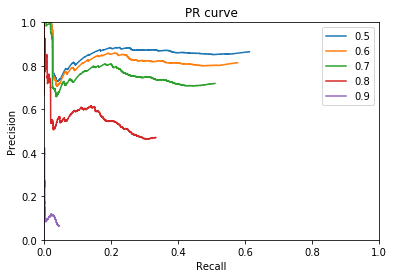

In [41]:
for i in range (len(recall_list_list)):
    plt.plot(recall_list_list[i], precision_list_list[i], label = str(iou_thresholds[i]))

plt.xlim(0,1)
plt.ylim(0,1)
plt.title("PR curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

# Analysis for Bus

In [42]:
precision_list_list = []
recall_list_list = []
for k in range (len(iou_thresholds)):
    iou_threshold = iou_thresholds[k]
    print(iou_threshold)
    all_iou = []
    tp_list = []
    fp_list = []
    tp = 0
    fp = 0
    fn = 0
    tn = 0
    ground_no_predict_no = 0
    ground_yes_predict_no = 0
    ground_no_predict_yes = 0
    ground_yes_predict_yes = 0
#     confidences = []
    precision_list = []
    recall_list = []
    tpr_list = []
    fpr_list = []

    IDs_ground = dict_ground_bus['image_id'] # List of integers
    IDs_pred = dict_pred_bus['image_id']

    p_ground = dict_ground_bus['frame_ground'] # List of dictionaries
    p_pred = dict_pred_bus['frame_predictions']

    if len(p_ground) != len(p_pred):
        print("Number of images in prediction phase and ground truth are not same")
    else:
        for l, pp in enumerate (p_pred): # Iterate through all images.
            pp_ground = p_ground[l]
            pp_pred = pp
            
            ground_truth = pp_ground['locations']
            loc = pp_pred['locations']
            ious = []
            predictions = []
            c1 = len(loc)
            c2 = len(ground_truth)
            
            if c1==0 and c2==0:
                tn = tn + 1
                ground_no_predict_no = ground_no_predict_no + 1
                continue
            elif c1==0 and c2 !=0:
                ground_yes_predict_no = ground_yes_predict_no + 1
                fn = fn + 1
                continue
            elif c1!=0 and c2==0:
                ground_no_predict_yes = ground_no_predict_yes + 1
                fp = fp + 1
                continue
# The the purpose of below nested loop is to look for the match of ground box and predicted box.
# Inner loop looks for the match of a single ground box.
# Outer loop looks for all predicting boxes of a particular frame.
            for i in range (c1): # Iterate through a single image
                dis = []
                for j in range (c2):
                    d = bb_intersection_over_union(loc[i], ground_truth[j])
                    dis.append(d)
#                 print(dis)

                iou_box = max(dis) # At maximum value, there is overlap in ground and predicted box
                ious.append(iou_box)
                index = dis.index(iou_box)
#                 confidences.append(conf_pred[index])
                if iou_box > iou_threshold:
                    tp_list.append(1)
                    fp_list.append(0)
                    tp = tp+1
                else:
                    tp_list.append(0)
                    fp_list.append(1)
                    fp = fp + 1
                precision = tp/(tp+fp)
                recall = tp/total_ground_bus
                precision_list.append(precision)
                recall_list.append(recall)             
                iou_img = sum(ious)/len(ious)
                all_iou.append(iou_img)
                if tn+fp != 0:
                    fpr_list.append(fp/(tn+fp))
                    tpr_list.append(precision)
                
        if len(all_iou) != 0:
            avg_iou = sum(all_iou)/len(all_iou)
            print("Avergae IoU for all images: {}".format(avg_iou))

        AP = CalculateAveragePrecision(recall_list, precision_list)
        print("Average Precision: "+str(AP))

        precision_list_list.append(precision_list)
        recall_list_list.append(recall_list)

0.5
Average Precision: 0
0.6
Average Precision: 0
0.7
Average Precision: 0
0.8
Average Precision: 0
0.9
Average Precision: 0


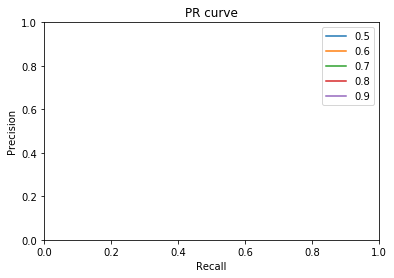

In [43]:
for i in range (len(recall_list_list)):
    plt.plot(recall_list_list[i], precision_list_list[i], label = str(iou_thresholds[i]))


plt.xlim(0,1)
plt.ylim(0,1)
plt.title("PR curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()